In [16]:
uv sync

/Users/jefersonsouza/Developments/analise-dados-ensino-superior/.venv/bin/python: No module named uv
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Análise de Evasão em Cursos de Informática

Neste notebook, vamos analisar dados de evasão em cursos superiores, focando especificamente nos cursos da área de informática (como Engenharia de Software, Ciência da Computação, etc.).


Os dados utilizados são do período 2010-2019 e contêm informações sobre trajetória acadêmica dos estudantes.


In [18]:

try:
    df = pd.read_excel('indicadores_trajetoria_educacao_superior_2010_2019.xlsx', engine='openpyxl')
    print(f"Dados carregados: {df.shape[0]} linhas x {df.shape[1]} colunas")
    
    print("\nPrimeiras linhas:")
    print(df.head())
    
    print("\nColunas disponíveis:")
    for col in df.columns:
        print(f"- {col}")
        
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")

Dados carregados: 259231 linhas x 31 colunas

Primeiras linhas:
  Código da Instituição                  Nome da Instituição  \
0                     1  UNIVERSIDADE FEDERAL DE MATO GROSSO   
1                     1  UNIVERSIDADE FEDERAL DE MATO GROSSO   
2                     1  UNIVERSIDADE FEDERAL DE MATO GROSSO   
3                     1  UNIVERSIDADE FEDERAL DE MATO GROSSO   
4                     1  UNIVERSIDADE FEDERAL DE MATO GROSSO   

   Categoria Administrativa  Organização Acadêmica  \
0                      1.00                   1.00   
1                      1.00                   1.00   
2                      1.00                   1.00   
3                      1.00                   1.00   
4                      1.00                   1.00   

   Código do Curso de Graduação Nome do Curso de Graduação  \
0                          1.00                    DIREITO   
1                          1.00                    DIREITO   
2                          1.00         

## Filtrar Cursos de Informática

Nesta etapa, vamos filtrar apenas os cursos relacionados à área de informática para focar nossa análise nesse campo específico.


In [19]:
cursos_informatica = [
    'CIÊNCIA DA COMPUTAÇÃO',
    'ENGENHARIA DE SOFTWARE',
    'ENGENHARIA DA COMPUTAÇÃO',
    'ANÁLISE DE SISTEMAS',
    'ANÁLISE E DESENVOLVIMENTO DE SISTEMAS',
    'SISTEMAS DE INFORMAÇÃO',
    'TECNOLOGIA DA INFORMAÇÃO',
    'PROCESSAMENTO DE DADOS',
    'BANCO DE DADOS',
    'REDES DE COMPUTADORES',
    'SEGURANÇA DA INFORMAÇÃO',
    'DESENVOLVIMENTO DE SOFTWARE',
    'INFORMÁTICA',
    'DESENVOLVIMENTO WEB',
    'COMPUTAÇÃO',
    'JOGOS DIGITAIS',
    'DESENVOLVIMENTO DE JOGOS DIGITAIS',
    'GESTÃO DE TECNOLOGIA DA INFORMAÇÃO',
    'CIÊNCIAS DA COMPUTAÇÃO',
    'ENGENHARIA DE COMPUTAÇÃO',
    'SISTEMAS PARA INTERNET',
    'WEB DESIGN E PROGRAMAÇÃO'
]

df_info = df[df['Nome do Curso de Graduação'].isin(cursos_informatica)]

print(f"Registros encontrados de cursos de informática (filtro específico): {len(df_info)}")
print(f"Cursos únicos encontrados: {df_info['Nome do Curso de Graduação'].nunique()}")

# Se o filtro exato for muito restritivo, usar método alternativo
if len(df_info) < 100:
    print("\nUsando método alternativo de filtragem...")
    
    palavras_chave_especificas = [
        'computação',
        'software',
        'informática',
        'dados',
        'sistemas de informação',
        'desenvolvimento de sistemas',
        'programação',
        'tecnologia da informação'
    ]
    
    cursos_filtrados = []
    for idx, row in df.iterrows():
        nome_curso = str(row['Nome do Curso de Graduação']).lower()
        
        if any(f" {kw} " in f" {nome_curso} " or nome_curso.startswith(kw) or nome_curso.endswith(kw) 
               for kw in palavras_chave_especificas):
            cursos_filtrados.append(idx)
    
    df_info = df.loc[cursos_filtrados]
    
    print(f"Registros encontrados com método alternativo: {len(df_info)}")
    print(f"Cursos únicos encontrados: {df_info['Nome do Curso de Graduação'].nunique()}")

print("\nCursos encontrados:")
for curso in sorted(df_info['Nome do Curso de Graduação'].unique()):
    print(f"- {curso}")

if len(df_info) == 0:
    print("ALERTA: Nenhum curso de informática encontrado. Verifique as palavras-chave ou os nomes dos cursos.")

Registros encontrados de cursos de informática (filtro específico): 16030
Cursos únicos encontrados: 18

Cursos encontrados:
- ANÁLISE DE SISTEMAS
- ANÁLISE E DESENVOLVIMENTO DE SISTEMAS
- BANCO DE DADOS
- CIÊNCIA DA COMPUTAÇÃO
- CIÊNCIAS DA COMPUTAÇÃO
- COMPUTAÇÃO
- ENGENHARIA DA COMPUTAÇÃO
- ENGENHARIA DE COMPUTAÇÃO
- ENGENHARIA DE SOFTWARE
- INFORMÁTICA
- JOGOS DIGITAIS
- PROCESSAMENTO DE DADOS
- REDES DE COMPUTADORES
- SEGURANÇA DA INFORMAÇÃO
- SISTEMAS DE INFORMAÇÃO
- SISTEMAS PARA INTERNET
- TECNOLOGIA DA INFORMAÇÃO
- WEB DESIGN E PROGRAMAÇÃO


## Preparação para Análise de Evasão

Antes de analisar a evasão por estado e região, precisamos:

1. Definir qual coluna representa a taxa de evasão nos dados (usaremos "Taxa de Desistência Acumulada - TODA")
2. Verificar as estatísticas básicas dessa coluna para entender sua distribuição
3. Criar mapeamentos para os códigos de estados e regiões, permitindo que utilizemos os nomes completos em nossa análise e visualizações

Estes mapeamentos transformarão códigos numéricos (como 35 para São Paulo) em nomes legíveis, tornando nossos resultados mais fáceis de interpretar.

In [20]:
coluna_evasao = 'Taxa de Desistência Acumulada - TODA'

print(f"Estatísticas de {coluna_evasao}:")
print(df_info[coluna_evasao].describe())

mapa_estados = {
    11: 'Rondônia', 12: 'Acre', 13: 'Amazonas', 14: 'Roraima', 15: 'Pará',
    16: 'Amapá', 17: 'Tocantins', 21: 'Maranhão', 22: 'Piauí', 23: 'Ceará',
    24: 'Rio Grande do Norte', 25: 'Paraíba', 26: 'Pernambuco', 27: 'Alagoas',
    28: 'Sergipe', 29: 'Bahia', 31: 'Minas Gerais', 32: 'Espírito Santo',
    33: 'Rio de Janeiro', 35: 'São Paulo', 41: 'Paraná', 42: 'Santa Catarina',
    43: 'Rio Grande do Sul', 50: 'Mato Grosso do Sul', 51: 'Mato Grosso',
    52: 'Goiás', 53: 'Distrito Federal'
}

mapa_regioes = {
    1: 'Norte',
    2: 'Nordeste',
    3: 'Sudeste',
    4: 'Sul',
    5: 'Centro-Oeste'
}

Estatísticas de Taxa de Desistência Acumulada - TODA:
count   16030.00
mean       54.06
std        26.64
min         0.00
25%        35.16
50%        57.89
75%        74.21
max       100.00
Name: Taxa de Desistência Acumulada - TODA, dtype: float64


## Análise de Evasão por Estado (UF)

Nesta etapa, vamos identificar qual curso de informática apresenta a maior taxa de evasão em cada estado brasileiro.

O processo envolve:
1. Agrupar os dados por UF e curso, calculando a taxa média de evasão para cada combinação
2. Para cada estado, identificar o curso com a maior taxa de evasão
3. Ordenar os resultados da maior para a menor taxa de evasão
4. Adicionar os nomes dos estados para melhor legibilidade
5. Visualizar os resultados em forma de tabela e gráfico

Esta análise nos permitirá identificar padrões regionais na evasão de cursos específicos e verificar se existem estados onde determinados cursos de informática apresentam taxas de evasão significativamente maiores.

Curso com MAIOR taxa de evasão por estado (UF):
              Nome da UF             Nome do Curso de Graduação  \
2               Rondônia                             COMPUTAÇÃO   
149               Paraná                 PROCESSAMENTO DE DADOS   
85               Alagoas               TECNOLOGIA DA INFORMAÇÃO   
35             Tocantins                  REDES DE COMPUTADORES   
31                 Amapá                 SISTEMAS DE INFORMAÇÃO   
113       Espírito Santo               ENGENHARIA DE COMPUTAÇÃO   
45                 Piauí                             COMPUTAÇÃO   
156       Santa Catarina                         JOGOS DIGITAIS   
190                Goiás               ENGENHARIA DA COMPUTAÇÃO   
15              Amazonas                  REDES DE COMPUTADORES   
199     Distrito Federal                  CIÊNCIA DA COMPUTAÇÃO   
102         Minas Gerais                         BANCO DE DADOS   
92                 Bahia  ANÁLISE E DESENVOLVIMENTO DE SISTEMAS   
80            

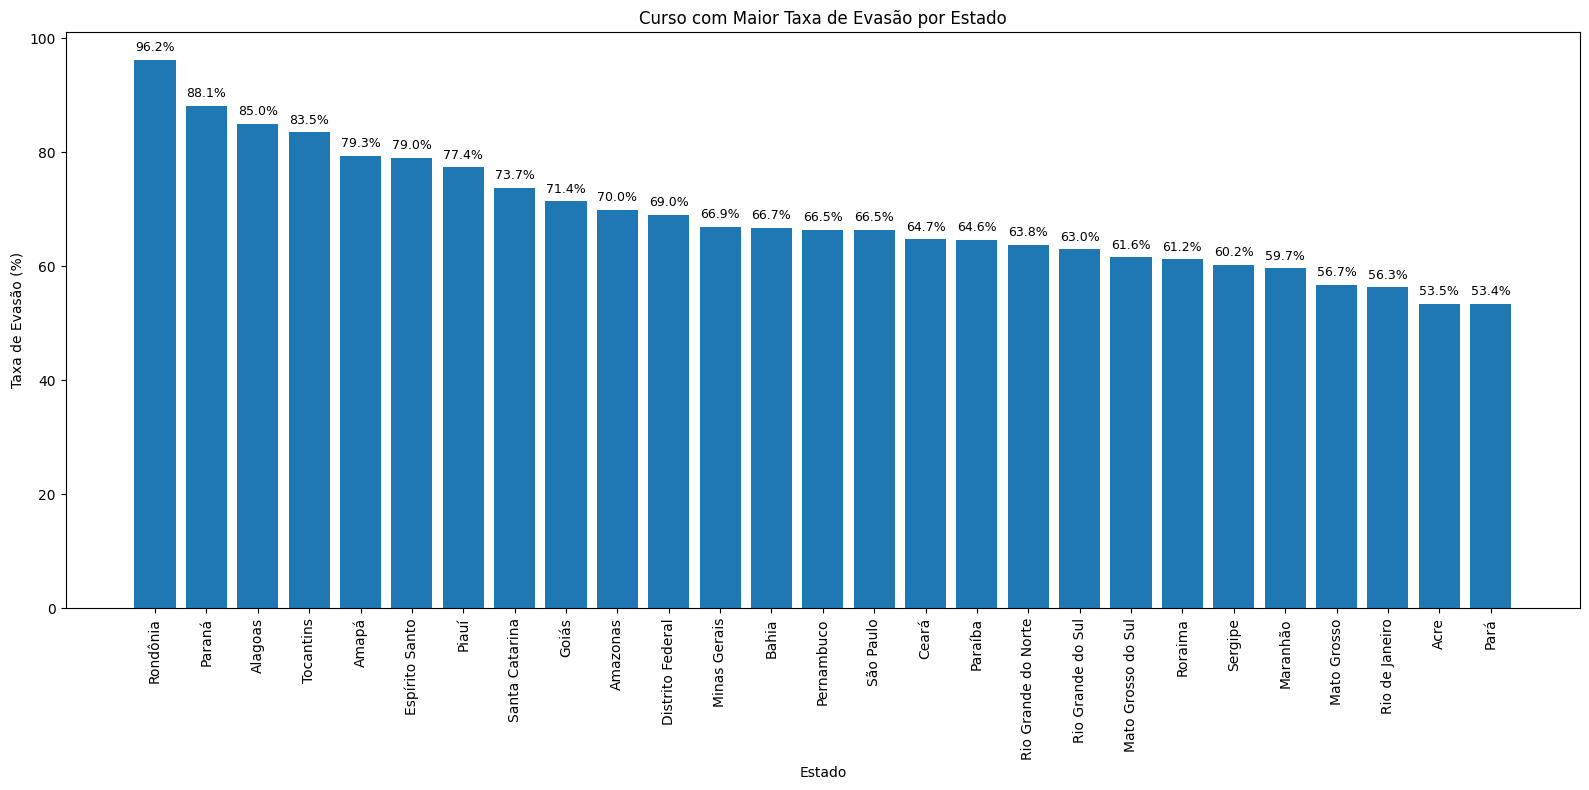

In [21]:
evasao_por_uf = df_info.groupby(['Código da Unidade Federativa do Curso', 'Nome do Curso de Graduação'])[coluna_evasao].mean().reset_index()

# Para cada estado, encontrar o curso com maior evasão
maior_evasao_por_uf = evasao_por_uf.loc[evasao_por_uf.groupby('Código da Unidade Federativa do Curso')[coluna_evasao].idxmax()]
maior_evasao_por_uf = maior_evasao_por_uf.sort_values(coluna_evasao, ascending=False)

maior_evasao_por_uf['Nome da UF'] = maior_evasao_por_uf['Código da Unidade Federativa do Curso'].map(mapa_estados)

print("Curso com MAIOR taxa de evasão por estado (UF):")
display_df = maior_evasao_por_uf[['Nome da UF', 'Nome do Curso de Graduação', coluna_evasao]]
print(display_df)

plt.figure(figsize=(16, 8))
bars = plt.bar(maior_evasao_por_uf['Nome da UF'], maior_evasao_por_uf[coluna_evasao])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Curso com Maior Taxa de Evasão por Estado')
plt.xlabel('Estado')
plt.ylabel('Taxa de Evasão (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Análise de Evasão por Região

Agora vamos analisar a evasão em uma escala mais ampla, identificando qual curso de informática tem a maior taxa de evasão em cada região do Brasil (Norte, Nordeste, Centro-Oeste, Sudeste e Sul).

Esta análise nos permite:
1. Identificar padrões regionais mais abrangentes
2. Comparar as taxas de evasão entre as diferentes regiões do país
3. Verificar se existe um padrão consistente de cursos com alta evasão em determinadas regiões

Seguiremos uma abordagem similar à análise por estado, mas agrupando os dados por região geográfica em vez de por UF.

Curso com MAIOR taxa de evasão por região:
   Nome da Região Nome do Curso de Graduação  \
47            Sul     PROCESSAMENTO DE DADOS   
23       Nordeste   TECNOLOGIA DA INFORMAÇÃO   
57   Centro-Oeste   ENGENHARIA DE COMPUTAÇÃO   
10          Norte     SISTEMAS PARA INTERNET   
26        Sudeste             BANCO DE DADOS   

    Taxa de Desistência Acumulada - TODA  
47                                 88.13  
23                                 85.00  
57                                 65.33  
10                                 65.04  
26                                 64.77  


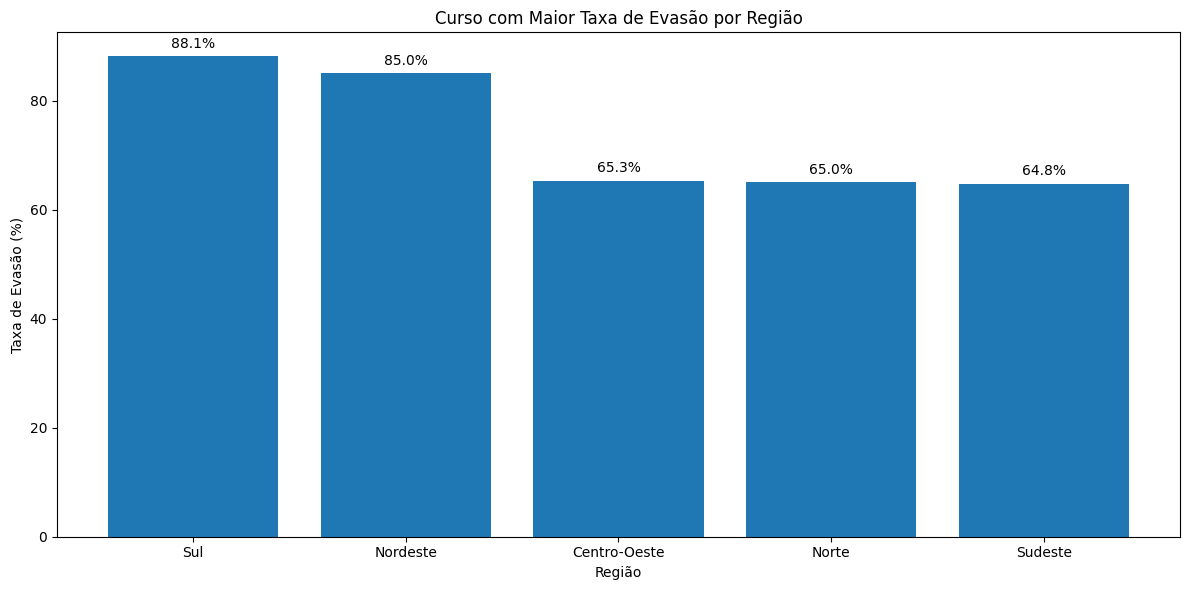

In [22]:
evasao_por_regiao = df_info.groupby(['Código da Região Geográfica do Curso', 'Nome do Curso de Graduação'])[coluna_evasao].mean().reset_index()

# Para cada região, encontrar o curso com maior evasão
maior_evasao_por_regiao = evasao_por_regiao.loc[evasao_por_regiao.groupby('Código da Região Geográfica do Curso')[coluna_evasao].idxmax()]
maior_evasao_por_regiao = maior_evasao_por_regiao.sort_values(coluna_evasao, ascending=False)

maior_evasao_por_regiao['Nome da Região'] = maior_evasao_por_regiao['Código da Região Geográfica do Curso'].map(mapa_regioes)

print("Curso com MAIOR taxa de evasão por região:")
print(maior_evasao_por_regiao[['Nome da Região', 'Nome do Curso de Graduação', coluna_evasao]])

plt.figure(figsize=(12, 6))
bars = plt.bar(maior_evasao_por_regiao['Nome da Região'], maior_evasao_por_regiao[coluna_evasao])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Curso com Maior Taxa de Evasão por Região')
plt.xlabel('Região')
plt.ylabel('Taxa de Evasão (%)')
plt.tight_layout()
plt.show()

## Ranking Geral de Cursos por Taxa de Evasão

Após analisar a evasão por estado e região, vamos criar um ranking geral que mostra quais cursos de informática apresentam as maiores taxas médias de evasão em todo o país.

Esta visão mais ampla nos permite:
1. Identificar quais cursos consistentemente apresentam problemas de evasão, independentemente da região
2. Comparar as taxas médias de evasão entre os diferentes cursos
3. Visualizar a diferença na taxa de evasão entre os cursos

Este ranking fornece uma perspectiva nacional sobre quais cursos podem necessitar de maior atenção em termos de políticas de retenção de estudantes.

Ranking de cursos de informática por taxa média de evasão:
Nome do Curso de Graduação
TECNOLOGIA DA INFORMAÇÃO                85.00
WEB DESIGN E PROGRAMAÇÃO                66.42
PROCESSAMENTO DE DADOS                  66.34
BANCO DE DADOS                          64.77
SEGURANÇA DA INFORMAÇÃO                 58.25
SISTEMAS PARA INTERNET                  56.54
REDES DE COMPUTADORES                   56.18
ENGENHARIA DE COMPUTAÇÃO                55.12
CIÊNCIA DA COMPUTAÇÃO                   54.16
COMPUTAÇÃO                              54.14
SISTEMAS DE INFORMAÇÃO                  54.12
ANÁLISE E DESENVOLVIMENTO DE SISTEMAS   52.31
ENGENHARIA DA COMPUTAÇÃO                51.91
JOGOS DIGITAIS                          51.25
INFORMÁTICA                             46.66
ENGENHARIA DE SOFTWARE                  41.16
CIÊNCIAS DA COMPUTAÇÃO                  34.55
ANÁLISE DE SISTEMAS                     34.00
Name: Taxa de Desistência Acumulada - TODA, dtype: float64


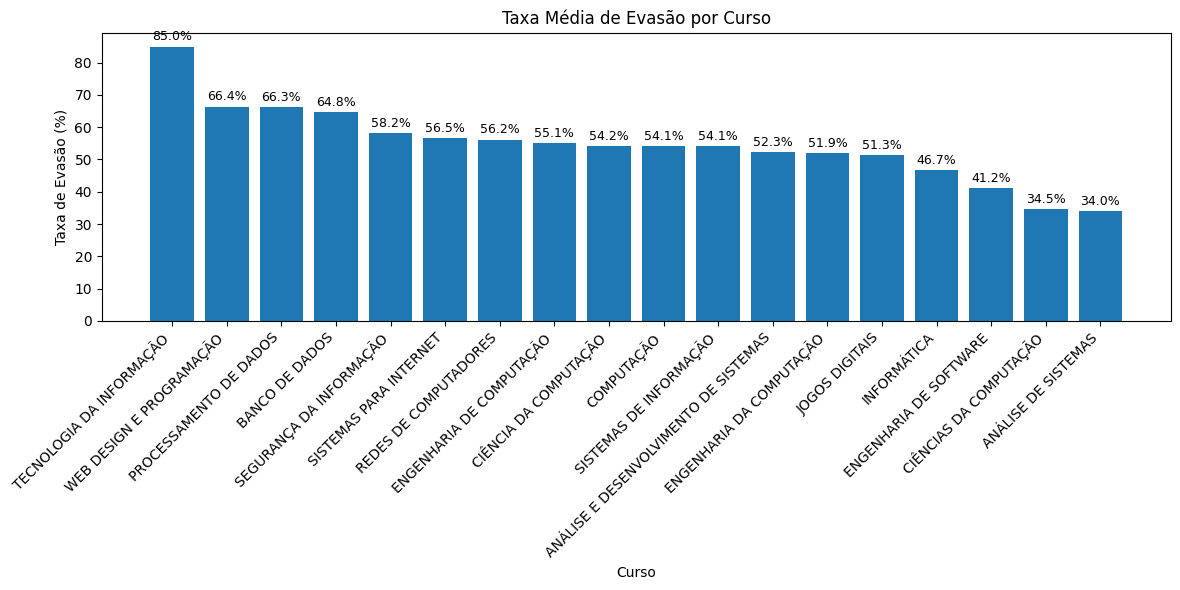

In [23]:
evasao_media_por_curso = df_info.groupby('Nome do Curso de Graduação')[coluna_evasao].mean().sort_values(ascending=False)

print("Ranking de cursos de informática por taxa média de evasão:")
print(evasao_media_por_curso)

plt.figure(figsize=(12, 6))
bars = plt.bar(evasao_media_por_curso.index, evasao_media_por_curso.values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=0  
    )

plt.title('Taxa Média de Evasão por Curso')
plt.xlabel('Curso')
plt.ylabel('Taxa de Evasão (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preparação para Clusterização com K-Means

Agora vamos aplicar o algoritmo K-Means para identificar padrões naturais nos dados de evasão de cursos de informática. 

O K-Means é um algoritmo de aprendizado não supervisionado que agrupa dados em clusters com base na similaridade entre eles. Diferente do KNN (que é supervisionado), o K-Means não requer um rótulo predefinido - ele descobre grupos naturalmente presentes nos dados.

Nesta etapa, vamos:
1. Selecionar os atributos relevantes para a clusterização
2. Tratar valores ausentes (NaN)
3. Padronizar os dados para garantir que todas as variáveis tenham a mesma importância

Esta preparação é crucial para que o algoritmo K-Means funcione corretamente e identifique padrões significativos nos dados.

In [24]:
colunas_excluir = [
    'Código da Instituição', 'Código do Curso de Graduação', 
    'Código da Unidade Federativa do Curso', 'Código do Município do Curso', 
    'Código da Região Geográfica do Curso', 'Ano de Ingresso', 'Ano de Referência'
]

# Obter todas as colunas numéricas
colunas_numericas = df_info.select_dtypes(include=['number']).columns

atributos = [col for col in colunas_numericas if col not in colunas_excluir]

print(f"Usando {len(atributos)} atributos para clusterização:")
for attr in atributos:
    print(f"- {attr}")

# Preparar dados para clusterização
X = df_info[atributos].copy()
X = X.fillna(X.mean())

# Padronizar os dados para que todas as variáveis tenham a mesma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nDados preparados: {X_scaled.shape[0]} registros x {X_scaled.shape[1]} atributos")

Usando 19 atributos para clusterização:
- Categoria Administrativa
- Organização Acadêmica
- Grau Acadêmico
- Modalidade de Ensino
- Código da Grande Área do Curso segundo a classificação CINE BRASIL
- Prazo de Integralização em Anos
- Ano de Integralização do Curso
- Prazo de Acompanhamento do Curso em anos
- Ano Máximo de Acompanhamento do Curso
- Quantidade de Ingressantes no Curso
- Quantidade de Permanência no Curso no ano de referência
- Quantidade de Concluintes no Curso no ano de referência
- Quantidade de Desistência no Curso no ano de referência
- Quantidade de Falecimentos no Curso no ano de referência
- Taxa de Permanência - TAP
- Taxa de Conclusão Acumulada - TCA
- Taxa de Desistência Acumulada - TODA
- Taxa de Conclusão Anual - TCAN
- Taxa de Desistência Anual - TDAN

Dados preparados: 16030 registros x 19 atributos


## Determinar o Número Ideal de Clusters (Método Elbow)

Uma questão fundamental ao usar K-Means é determinar o número ideal de clusters (k) a ser utilizado. Um número muito pequeno de clusters pode não capturar adequadamente os padrões nos dados, enquanto um número muito grande pode levar a clusters excessivamente fragmentados.

O Método Elbow é uma técnica popular para determinar o valor ideal de k. Ele consiste em:

1. Executar K-Means com diferentes valores de k
2. Para cada valor, calcular a inércia (soma das distâncias quadradas de cada ponto ao centroide do seu cluster)
3. Plotar um gráfico de inércia versus k
4. Procurar um "cotovelo" (elbow) no gráfico - o ponto onde adicionar mais clusters não reduz substancialmente a inércia

Este ponto de inflexão representa um bom compromisso entre a complexidade do modelo (número de clusters) e sua capacidade de explicar os dados.

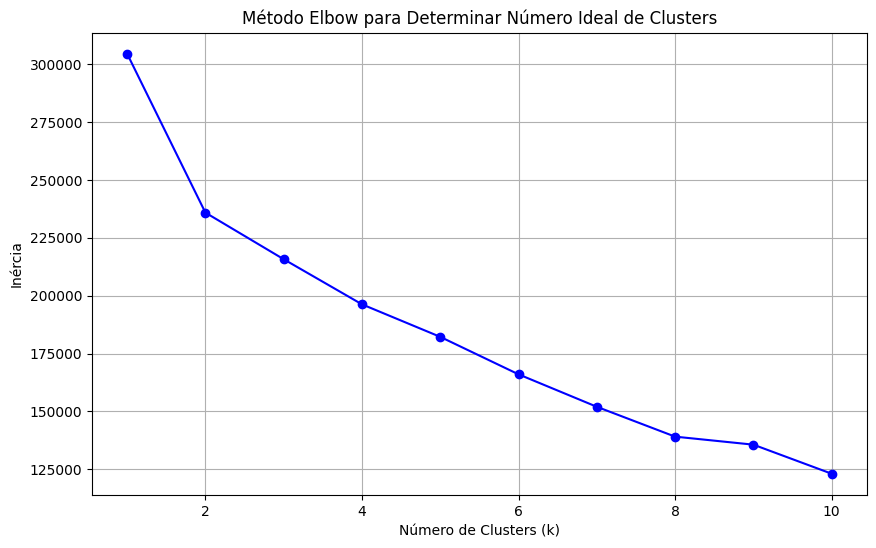

k = 1: Inércia = 304570.00
k = 2: Inércia = 235901.35
k = 3: Inércia = 215771.30
k = 4: Inércia = 196283.28
k = 5: Inércia = 182225.68
k = 6: Inércia = 166033.49
k = 7: Inércia = 152012.59
k = 8: Inércia = 139110.30
k = 9: Inércia = 135645.86
k = 10: Inércia = 123089.22


In [25]:
inertias = []
K_range = range(1, 11)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.title('Método Elbow para Determinar Número Ideal de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

for k, inertia in zip(K_range, inertias):
    print(f"k = {k}: Inércia = {inertia:.2f}")



## Aplicar K-Means com o Número Ideal de Clusters

Após determinar o número ideal de clusters usando o método Elbow, agora vamos aplicar o algoritmo K-Means com esse valor.

Nesta etapa:
1. Executamos o algoritmo K-Means com o número de clusters escolhido
2. Atribuímos cada curso a um cluster específico
3. Adicionamos essa informação de cluster ao nosso DataFrame original

Esta clusterização nos permitirá identificar grupos naturais de cursos que compartilham características semelhantes, possibilitando uma análise mais detalhada de cada grupo.

In [26]:
n_clusters = 2  # Escolhido a partir do gráfico do método Elbow

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_info['cluster'] = clusters

cluster_counts = df_info['cluster'].value_counts().sort_index()
print("Número de registros por cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} registros ({count/len(df_info)*100:.1f}%)")

cluster_evasao = df_info.groupby('cluster')[coluna_evasao].mean().sort_values()
print("\nTaxa média de evasão por cluster:")
for cluster, evasao in cluster_evasao.items():
    print(f"Cluster {cluster}: {evasao:.2f}%")

Número de registros por cluster:
Cluster 0: 8984 registros (56.0%)
Cluster 1: 7046 registros (44.0%)

Taxa média de evasão por cluster:
Cluster 0: 53.75%
Cluster 1: 54.46%


/var/folders/m2/rv7wx6w91qggrlw__bq7t0t40000gn/T/ipykernel_1248/3225104081.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info['cluster'] = clusters


## Análise Detalhada dos Clusters

Agora que temos nossos cursos agrupados em clusters, vamos analisar cada cluster em detalhe para entender suas características distintas.

Para cada cluster, vamos examinar:
1. **Informações gerais**: Número de registros e taxa média de evasão
2. **Composição por curso**: Quais cursos são mais comuns em cada cluster
3. **Distribuição geográfica**: Quais regiões e estados são predominantes
4. **Instituições**: Quais instituições aparecem com mais frequência
5. **Características dos atributos**: Como os valores médios dos atributos se comparam com a média geral

Esta análise nos ajudará a identificar padrões específicos associados a diferentes níveis de evasão, revelando potenciais fatores que influenciam esse fenômeno nos cursos de informática.

In [27]:
for cluster in range(n_clusters):
    df_cluster = df_info[df_info['cluster'] == cluster]
    
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster}:")
    print(f"{'='*50}")
    print(f"Número de registros: {len(df_cluster)} ({len(df_cluster)/len(df_info)*100:.1f}% do total)")
    print(f"Taxa média de evasão: {df_cluster[coluna_evasao].mean():.2f}%")
    print(f"Taxa mediana de evasão: {df_cluster[coluna_evasao].median():.2f}%")
    print(f"Intervalo de evasão: {df_cluster[coluna_evasao].min():.2f}% a {df_cluster[coluna_evasao].max():.2f}%")
    
    print("\nCursos mais frequentes neste cluster:")
    curso_counts = df_cluster['Nome do Curso de Graduação'].value_counts().head(5)
    for curso, count in curso_counts.items():
        pct = count / len(df_cluster) * 100
        print(f"- {curso}: {count} registros ({pct:.1f}%)")
    
    print("\nRegiões mais frequentes neste cluster:")
    regiao_counts = df_cluster['Código da Região Geográfica do Curso'].value_counts().head(5)
    for regiao, count in regiao_counts.items():
        if pd.isna(regiao):
            nome_regiao = "Região não informada"
        else:
            nome_regiao = mapa_regioes.get(int(regiao), f"Região-{int(regiao)}")
        pct = count / len(df_cluster) * 100
        print(f"- {nome_regiao}: {count} registros ({pct:.1f}%)")
    
    print("\nEstados mais frequentes neste cluster:")
    uf_counts = df_cluster['Código da Unidade Federativa do Curso'].value_counts().head(5)
    for uf, count in uf_counts.items():
        if pd.isna(uf):
            nome_uf = "UF não informada"
        else:
            nome_uf = mapa_estados.get(int(uf), f"UF-{int(uf)}")
        pct = count / len(df_cluster) * 100
        print(f"- {nome_uf}: {count} registros ({pct:.1f}%)")
    
    print("\nInstituições mais frequentes neste cluster:")
    instituicao_counts = df_cluster['Nome da Instituição'].value_counts().head(5)
    for instituicao, count in instituicao_counts.items():
        pct = count / len(df_cluster) * 100
        print(f"- {instituicao}: {count} registros ({pct:.1f}%)")
    
    print("\nEstatísticas dos principais atributos (médias):")
    for attr in atributos[:7]:  # Mostrar apenas os 7 primeiros atributos para não sobrecarregar
        mean_all = df_info[attr].mean()
        mean_cluster = df_cluster[attr].mean()
        diff_pct = ((mean_cluster - mean_all) / mean_all) * 100 if mean_all != 0 else 0
        print(f"- {attr}: {mean_cluster:.2f} ({'+' if diff_pct > 0 else ''}{diff_pct:.1f}% em relação à média geral)")


CLUSTER 0:
Número de registros: 8984 (56.0% do total)
Taxa média de evasão: 53.75%
Taxa mediana de evasão: 57.60%
Intervalo de evasão: 0.00% a 100.00%

Cursos mais frequentes neste cluster:
- SISTEMAS DE INFORMAÇÃO: 4031 registros (44.9%)
- CIÊNCIA DA COMPUTAÇÃO: 3070 registros (34.2%)
- ENGENHARIA DE COMPUTAÇÃO: 870 registros (9.7%)
- ENGENHARIA DA COMPUTAÇÃO: 300 registros (3.3%)
- COMPUTAÇÃO: 283 registros (3.2%)

Regiões mais frequentes neste cluster:
- Sudeste: 4381 registros (48.8%)
- Sul: 1580 registros (17.6%)
- Nordeste: 1400 registros (15.6%)
- Centro-Oeste: 930 registros (10.4%)
- Norte: 553 registros (6.2%)

Estados mais frequentes neste cluster:
- São Paulo: 2620 registros (29.2%)
- Minas Gerais: 1000 registros (11.1%)
- Rio Grande do Sul: 660 registros (7.3%)
- Rio de Janeiro: 590 registros (6.6%)
- Paraná: 500 registros (5.6%)

Instituições mais frequentes neste cluster:
- UNIVERSIDADE PAULISTA: 390 registros (4.3%)
- UNIVERSIDADE ESTÁCIO DE SÁ: 150 registros (1.7%)
- U

## Visualização dos Clusters com PCA

Para visualizar graficamente os clusters que identificamos, precisamos reduzir a dimensionalidade dos dados, já que temos múltiplos atributos e não podemos plotá-los diretamente em um gráfico bidimensional.

A Análise de Componentes Principais (PCA) é uma técnica que nos permite reduzir a dimensionalidade dos dados, preservando o máximo possível da variância original. Vamos reduzir nossos dados a 2 dimensões para poder visualizá-los em um gráfico de dispersão.

Nesta visualização:
1. Cada ponto representa um registro de curso
2. A cor de cada ponto indica a qual cluster ele pertence
3. Os pontos X marcam os centroides de cada cluster (o "centro" do cluster)
4. As duas dimensões do gráfico são os componentes principais, que representam combinações dos atributos originais

Esta visualização nos ajudará a entender como os clusters estão distribuídos no espaço de atributos e quão bem separados eles estão.

/var/folders/m2/rv7wx6w91qggrlw__bq7t0t40000gn/T/ipykernel_1248/1651849861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info['pca_x'] = X_pca[:, 0]
/var/folders/m2/rv7wx6w91qggrlw__bq7t0t40000gn/T/ipykernel_1248/1651849861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_info['pca_y'] = X_pca[:, 1]


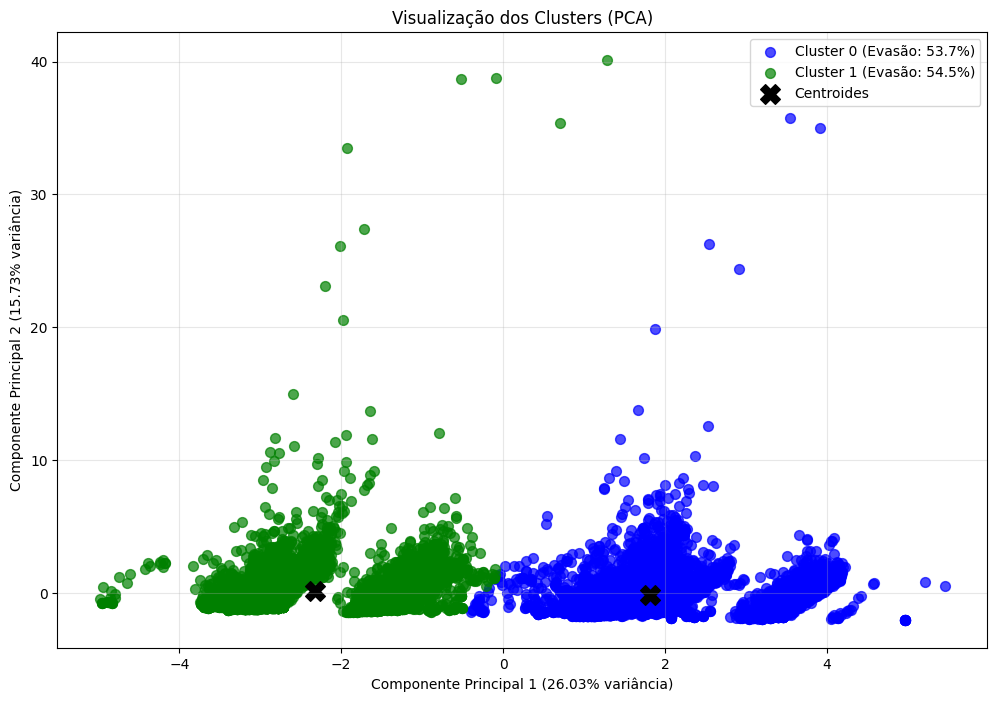

Variância explicada pelo primeiro componente: 26.03%
Variância explicada pelo segundo componente: 15.73%
Variância total explicada: 41.77%


In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_info['pca_x'] = X_pca[:, 0]
df_info['pca_y'] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for cluster in range(n_clusters):
    cluster_data = df_info[df_info['cluster'] == cluster]
    plt.scatter(
        cluster_data['pca_x'], 
        cluster_data['pca_y'],
        s=50, 
        c=colors[cluster], 
        label=f'Cluster {cluster} (Evasão: {cluster_data[coluna_evasao].mean():.1f}%)',
        alpha=0.7
    )

centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0], 
    centroids_pca[:, 1], 
    s=200, 
    marker='X', 
    c='black', 
    label='Centroides'
)

plt.title('Visualização dos Clusters (PCA)')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.2%} variância)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.2%} variância)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Variância explicada pelo primeiro componente: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variância explicada pelo segundo componente: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.2%}")

## Comparação da Evasão entre Clusters

Agora vamos examinar especificamente como a taxa de evasão se distribui entre os clusters identificados. Isso nos ajudará a entender se o algoritmo K-Means conseguiu identificar grupos com diferentes padrões de evasão.

Vamos visualizar esta comparação de duas maneiras:

1. **Boxplot**: Mostra a distribuição completa dos valores de evasão em cada cluster, incluindo a mediana, quartis e valores atípicos (outliers). Isso nos dá uma visão da variabilidade dentro de cada cluster.

2. **Gráfico de barras**: Apresenta a taxa média de evasão para cada cluster, permitindo uma comparação direta e fácil de interpretar.

Estas visualizações nos ajudarão a identificar quais clusters estão associados a maiores ou menores taxas de evasão, o que é fundamental para compreender os padrões presentes nos dados.

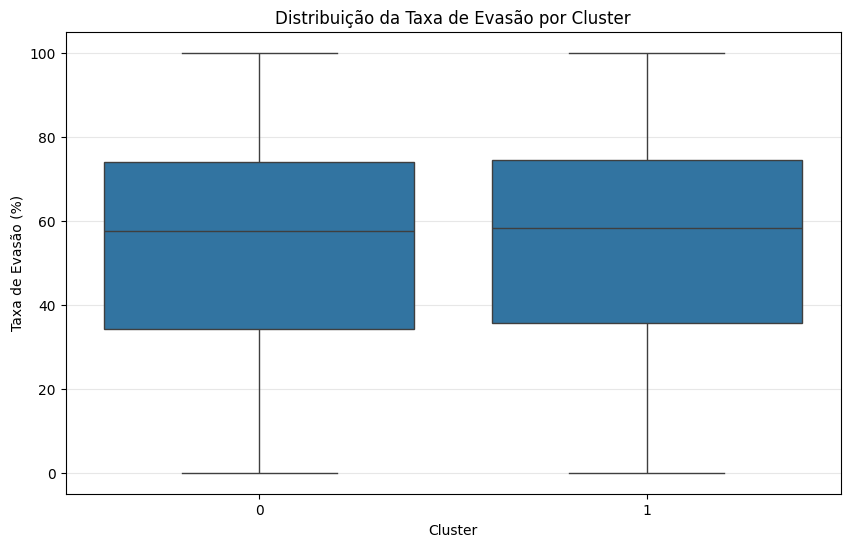

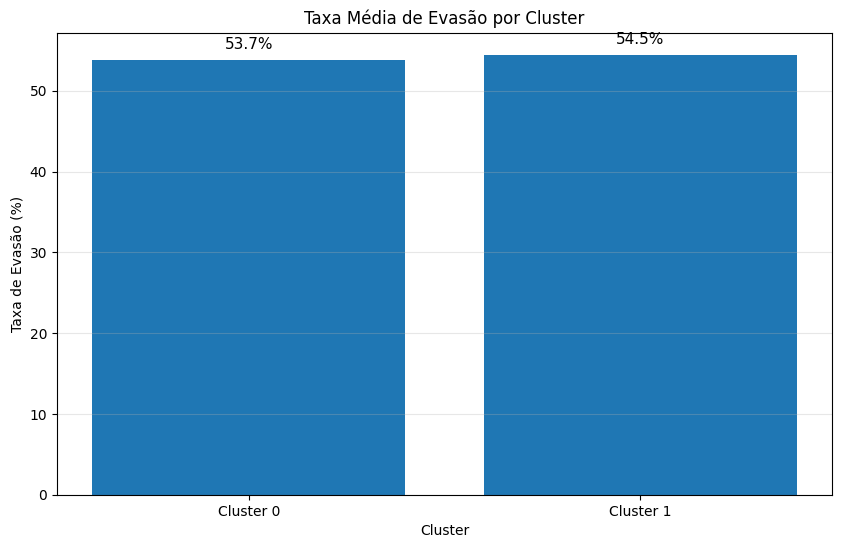


Estatísticas de evasão por cluster:
         count  mean  median  min    max
cluster                                 
0         8984 53.75   57.60 0.00 100.00
1         7046 54.46   58.33 0.00 100.00


In [29]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y=coluna_evasao, data=df_info)
plt.title('Distribuição da Taxa de Evasão por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Taxa de Evasão (%)')
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
evasao_media_cluster = df_info.groupby('cluster')[coluna_evasao].mean().sort_values()

bars = plt.bar(
    [f'Cluster {i}' for i in evasao_media_cluster.index], 
    evasao_media_cluster.values
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.title('Taxa Média de Evasão por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Taxa de Evasão (%)')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nEstatísticas de evasão por cluster:")
print(df_info.groupby('cluster')[coluna_evasao].agg(['count', 'mean', 'median', 'min', 'max']))

## Tabela Resumo das Características dos Clusters

Para finalizar nossa análise, vamos criar uma tabela resumida que sintetiza as principais características de cada cluster. Esta tabela facilitará a comparação entre os clusters e a identificação dos fatores mais relevantes.

A tabela incluirá:
- Tamanho do cluster (número de registros)
- Estatísticas de evasão (média, mediana, mínimo, máximo)
- Curso predominante
- Região geográfica predominante
- Valores médios dos principais atributos

Este resumo nos permitirá tirar conclusões sobre os padrões identificados e entender quais fatores estão mais fortemente associados a diferentes níveis de evasão nos cursos de informática.

In [30]:
cluster_summary = pd.DataFrame()

for cluster in range(n_clusters):
    df_cluster = df_info[df_info['cluster'] == cluster]
    
    curso_predominante = df_cluster['Nome do Curso de Graduação'].value_counts().index[0]
    
    regiao_code = df_cluster['Código da Região Geográfica do Curso'].value_counts().index[0]
    if pd.isna(regiao_code):
        regiao_predominante = "Não informada"
    else:
        regiao_predominante = mapa_regioes.get(int(regiao_code), f"Região-{int(regiao_code)}")
    
    summary = {
        'Cluster': cluster,
        'Tamanho': len(df_cluster),
        'Proporção (%)': len(df_cluster) / len(df_info) * 100,
        'Evasão Média (%)': df_cluster[coluna_evasao].mean(),
        'Evasão Mediana (%)': df_cluster[coluna_evasao].median(),
        'Evasão Mínima (%)': df_cluster[coluna_evasao].min(),
        'Evasão Máxima (%)': df_cluster[coluna_evasao].max(),
        'Curso Predominante': curso_predominante,
        'Região Predominante': regiao_predominante
    }
    
    for attr in atributos[:5]:  # Limitamos a 5 atributos para manter a tabela compacta
        summary[f'Média {attr}'] = df_cluster[attr].mean()
    
    cluster_summary = pd.concat([cluster_summary, pd.DataFrame([summary])], ignore_index=True)

cluster_summary = cluster_summary.sort_values('Evasão Média (%)')

print("\n=== RESUMO DOS CLUSTERS ===")
pd.set_option('display.float_format', '{:.2f}'.format)
print(cluster_summary[['Cluster', 'Tamanho', 'Proporção (%)', 'Evasão Média (%)', 'Evasão Mediana (%)', 'Curso Predominante', 'Região Predominante']])

df_info.to_csv('resultados_kmeans_evasao.csv', index=False)
print("\nResultados completos salvos em 'resultados_kmeans_evasao.csv'")

cluster_summary.to_csv('resumo_clusters_evasao.csv', index=False)
print("Tabela resumo salva em 'resumo_clusters_evasao.csv'")


=== RESUMO DOS CLUSTERS ===
   Cluster  Tamanho  Proporção (%)  Evasão Média (%)  Evasão Mediana (%)  \
0        0     8984          56.04             53.75               57.60   
1        1     7046          43.96             54.46               58.33   

                      Curso Predominante Região Predominante  
0                 SISTEMAS DE INFORMAÇÃO             Sudeste  
1  ANÁLISE E DESENVOLVIMENTO DE SISTEMAS             Sudeste  

Resultados completos salvos em 'resultados_kmeans_evasao.csv'
Tabela resumo salva em 'resumo_clusters_evasao.csv'


## Conclusões e Próximos Passos

Nossa análise com K-Means permitiu identificar padrões naturais nos dados de evasão de cursos de informática, agrupando-os em clusters com características semelhantes.

### Principais insights obtidos:

1. **Identificamos clusters com diferentes taxas de evasão**: Os clusters apresentam padrões distintos de evasão, o que sugere que fatores específicos podem estar influenciando este fenômeno.

2. **Composição dos clusters**: Observamos que determinados cursos, regiões e instituições são mais predominantes em certos clusters, o que pode indicar padrões específicos de evasão associados a esses fatores.

3. **Características distintivas**: Identificamos quais atributos são mais característicos de cada cluster, revelando possíveis fatores associados a maiores ou menores taxas de evasão.

4. **Visualização dos padrões**: A visualização com PCA nos permitiu observar como os clusters se distribuem no espaço de atributos e quão bem separados eles estão.

### Próximos passos possíveis:

1. **Análise aprofundada**: Investigar mais detalhadamente as características dos clusters com maior e menor evasão para identificar fatores de sucesso e desafios.

2. **Validação dos resultados**: Comparar os pa